# Курсовой проект по курсу "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

### Задание:
Ваша задача этом [соревновании](https://www.kaggle.com/competitions/real-estate-price-prediction-moscow) - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

### Целевая переменная:
Price

### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA

from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator  # Для отображения только натуральных чисел на осях
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [2]:
TRAIN_DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [4]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

16 числовых признаков (вместе с id) и 3 категориальных. 'LifeSquare' и 'Healthcare_1' имеют много пропусков

### Приведение типов

In [5]:
# Оптимизация типов данных
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    df['Rooms'] = df['Rooms'].astype('int64')
    df['KitchenSquare'] = df['KitchenSquare'].astype('int64')
    df['HouseFloor'] = df['HouseFloor'].astype('int64')
    df['Healthcare_1'] = df['Healthcare_1'].astype('int64')
    df['DistrictYear'] = df['DistrictYear'].astype('int64')
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                            and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                            and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [6]:
# train_df = reduce_memory_usage(train_df)
# test = reduce_memory_usage(test)

## 1. EDA
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

#### Целевая переменная

In [7]:
# Среднее значение и медиана
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

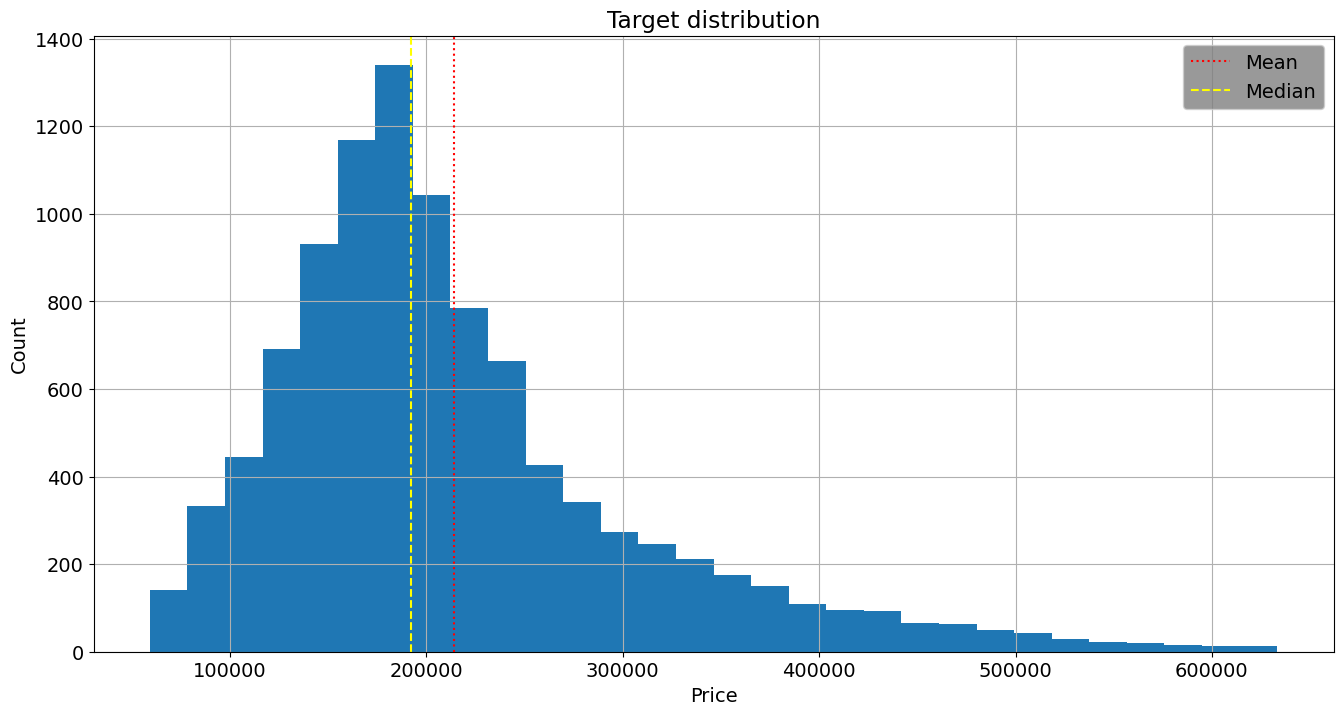

In [8]:
# Посмотрим график целевой переменной
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.axvline(target_mean, linestyle=':', label='Mean', color='red')
plt.axvline(target_median, linestyle='--', label='Median', color='yellow')

plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.legend(facecolor='gray')
plt.show()

График функции похож на логарифмически нормальное распределение

In [9]:
#train_df['Price'] = np.log2(train_df['Price'])

mu = 214138.86 and sigma = 92867.65


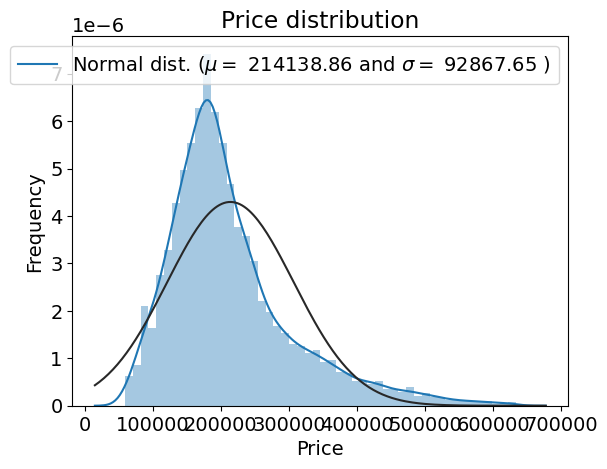

In [10]:
# Сравним с графиком нормального распределения
sns.distplot(train_df['Price'], fit=stats.norm)
#sns.set (rc={"figure.figsize":(7, 5)})
mu, sigma = stats.norm.fit(train_df['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')
plt.show()

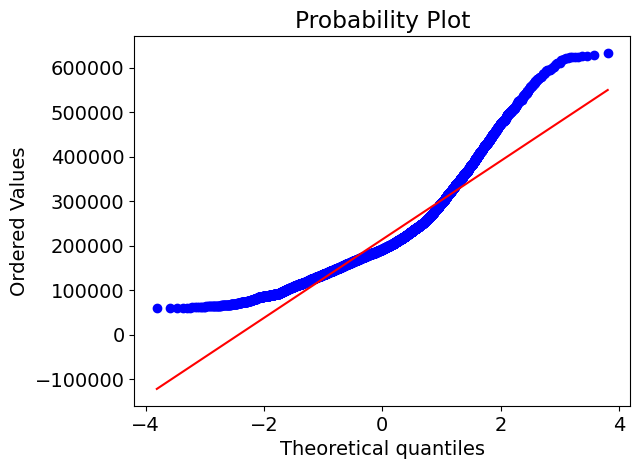

In [11]:
# QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['Price'], plot=plt)
plt.show()

In [12]:
#Проверим нулевую гипотезу, что данное распределение нормальное
stats.normaltest(train_df['Price'], axis=0)

NormaltestResult(statistic=2374.7689544862073, pvalue=0.0)

Так как pvalue=0, то нулевая гипотеза о нормальности распределения отклоняется

#### Количественные переменные

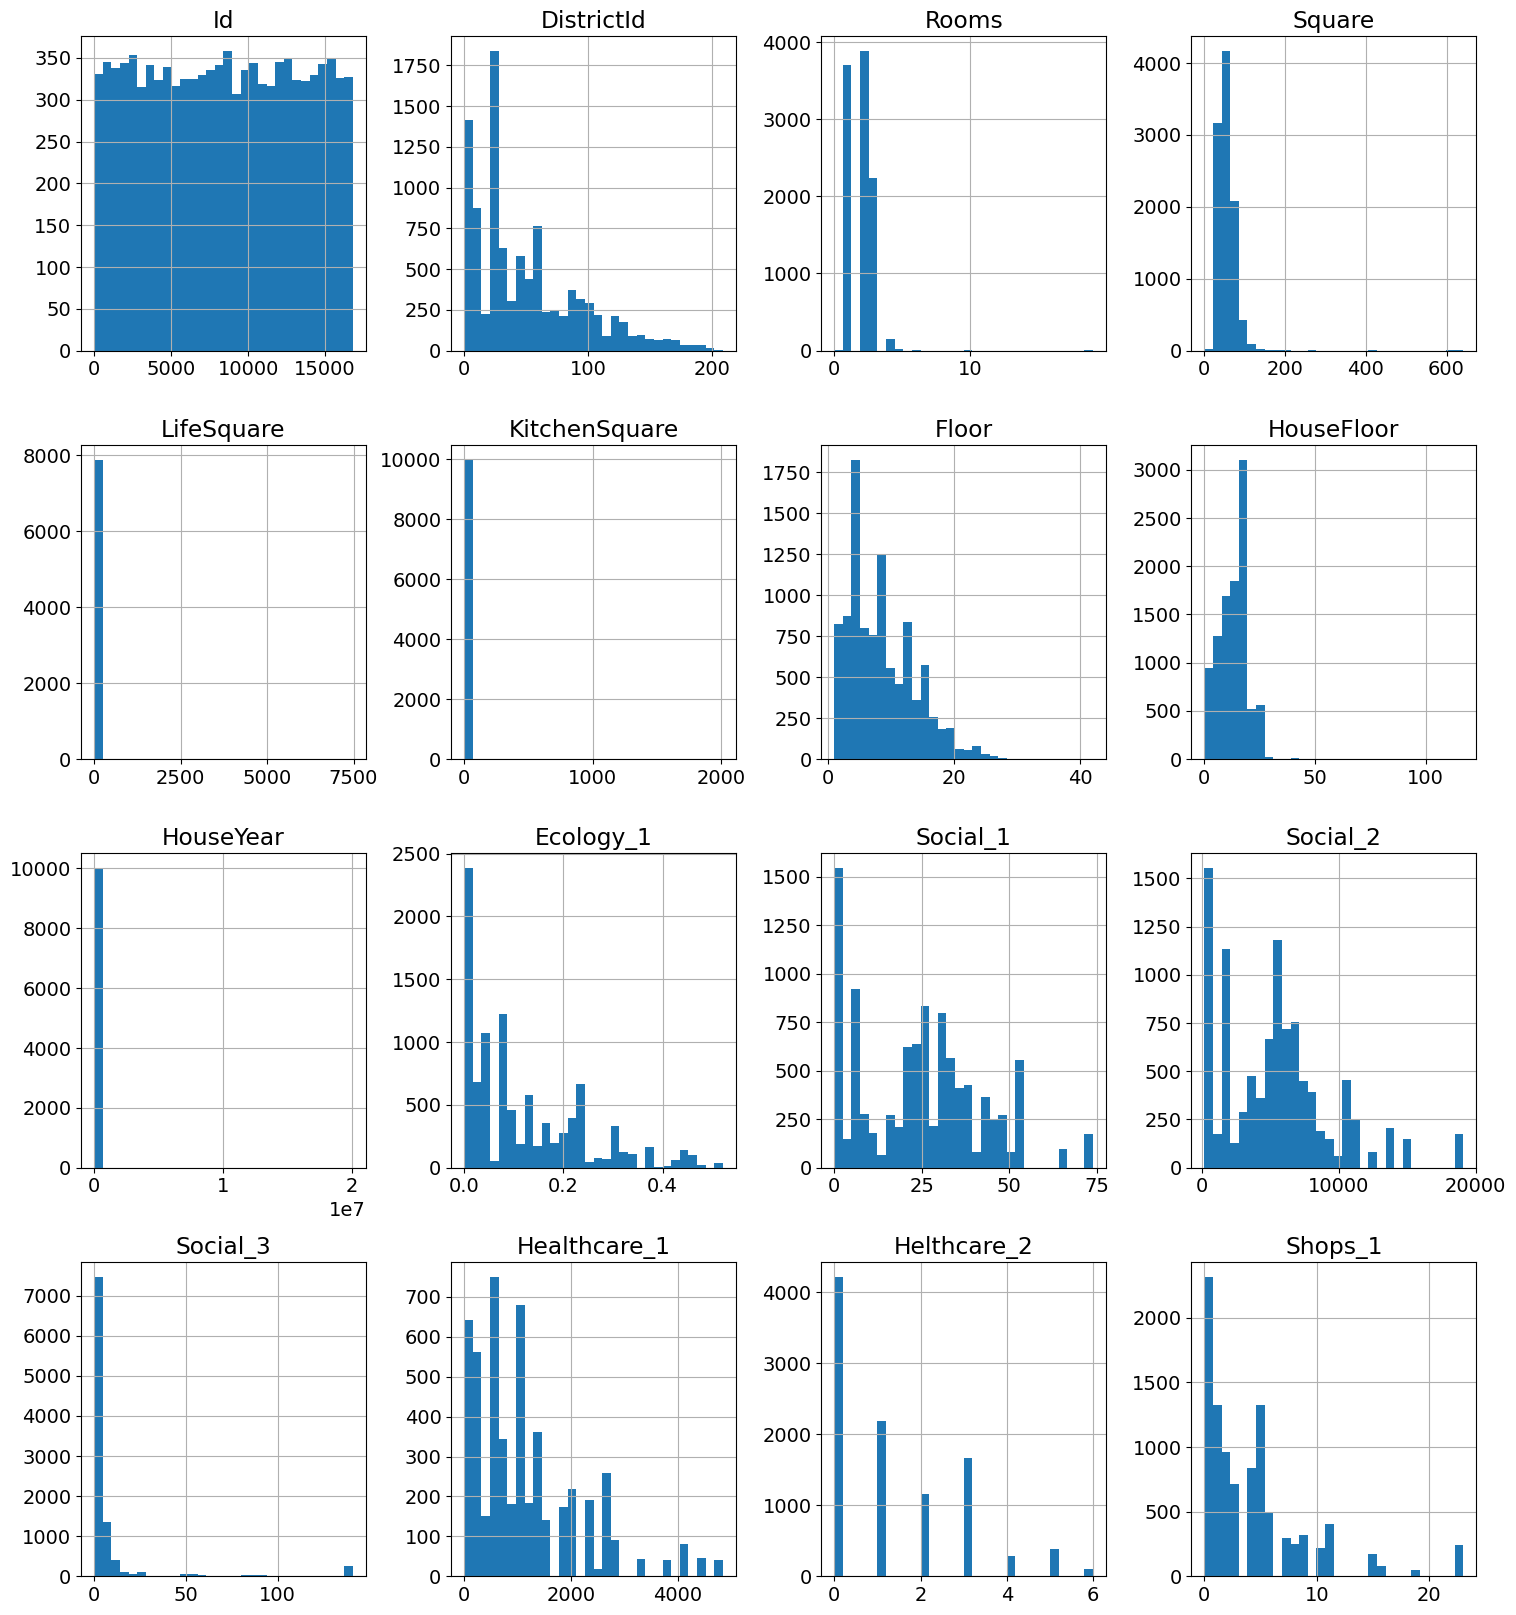

In [13]:
digital_features=train_df.select_dtypes(exclude='object').drop('Price', axis=1)
digital_features.hist(figsize=(18,20), bins=30)
plt.show()

'LifeSquare', 'KitchenSquare', 'HouseYear' явно имеют выбросы. 'Rooms', 'Square' и 'HouseFloor' требует детального рассмотрения

In [14]:
pd.options.display.float_format = '{:.2f}'.format
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.00,8383.41,4859.02,0.00,4169.50,8394.50,12592.50,16798.00
DistrictId,10000.00,50.40,43.59,0.00,20.00,36.00,75.00,209.00
Rooms,10000.00,1.89,0.84,0.00,1.00,2.00,2.00,19.00
Square,10000.00,56.32,21.06,1.14,41.77,52.51,65.90,641.07
LifeSquare,7887.00,37.20,86.24,0.37,22.77,32.78,45.13,7480.59
KitchenSquare,10000.00,6.27,28.56,0.00,1.00,6.00,9.00,2014.00
Floor,10000.00,8.53,5.24,1.00,4.00,7.00,12.00,42.00
HouseFloor,10000.00,12.61,6.78,0.00,9.00,13.00,17.00,117.00
HouseYear,10000.00,3990.17,200500.26,1910.00,1974.00,1977.00,2001.00,20052011.00
Ecology_1,10000.00,0.12,0.12,0.00,0.02,0.08,0.20,0.52


#### Номинативные (категориальные) переменные

In [15]:
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

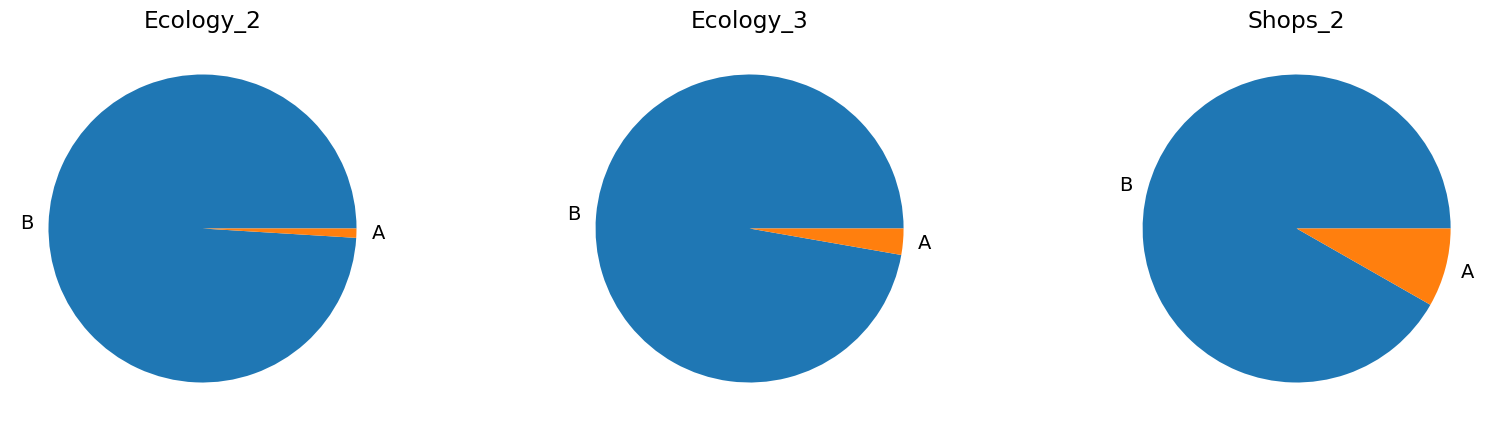

In [16]:
pie_ecology_2 = train_df['Ecology_2'].value_counts()
pie_ecology_3 = train_df['Ecology_3'].value_counts()
pie_shops_3 = train_df['Shops_2'].value_counts()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].pie(pie_ecology_2, labels=pie_ecology_2.index)
ax[1].pie(pie_ecology_3, labels=pie_ecology_3.index)
ax[2].pie(pie_shops_3, labels=pie_shops_3.index)

ax[0].set_title('Ecology_2')
ax[1].set_title('Ecology_3')
ax[2].set_title('Shops_2')

plt.show()

В номинальных переменных доминирует категория "B"

### Обработка выбросов

**Rooms**

In [17]:
train_df['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

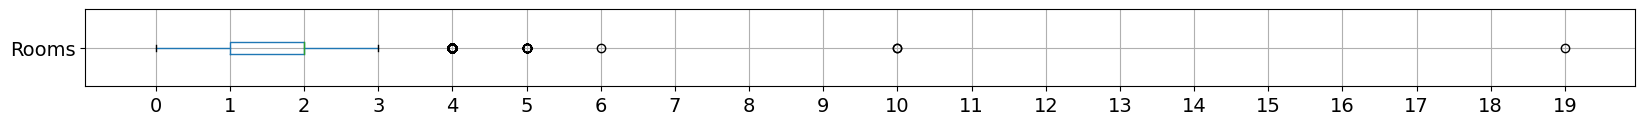

Общее количество выбросов 11


In [18]:
fig, ax = plt.subplots(figsize=(20, 1))
train_df.boxplot(column='Rooms', vert=False)
ax.xaxis.set_major_locator(MultipleLocator(base=1))
plt.show()
print('Общее количество выбросов', sum((train_df['Rooms'] == 0) | (train_df['Rooms'] > 6)))

In [19]:
# Квартиры с большим количеством комнат
train_df[train_df['Rooms'] > 6].sort_values(by='Price', ascending=False)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.00,59.06,36.22,10.00,22,22.00,2002,0.09,B,B,74,19083,2,NaN,5,15,B,317265.32
2728,14865,9,10.00,60.87,38.42,10.00,3,2.00,1994,0.16,B,B,25,5648,1,30.00,2,4,B,172329.27
6088,8491,1,19.00,42.01,21.78,7.00,17,17.00,2014,0.01,B,B,1,264,0,NaN,0,1,B,78364.62


Эти данные выглядят мусорными. Возможно, их нужно будет удалить

In [20]:
# Квартиры с "нулевыми" комнатами
train_df[train_df['Rooms'] == 0].sort_values(by='Price', ascending=False)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7644,7917,27,0.00,212.93,211.23,0.00,2,3.00,2008,0.21,B,B,9,1892,0,NaN,0,1,B,302211.26
9767,12638,27,0.00,138.43,136.22,0.00,4,3.00,2016,0.08,B,B,11,3097,0,NaN,0,0,B,268394.74
6401,9443,27,0.00,87.76,85.13,0.00,5,15.00,1977,0.21,B,B,9,1892,0,NaN,0,1,B,219281.92
5894,770,28,0.00,49.48,NaN,0.00,16,0.00,2015,0.12,B,B,30,6207,1,1183.00,1,0,B,217009.34
7929,456,6,0.00,81.49,NaN,0.00,4,0.00,1977,0.24,B,B,5,1564,0,540.00,0,0,B,212864.80
2194,3159,88,0.00,38.70,19.35,9.00,9,16.00,1982,0.13,B,B,43,8429,3,NaN,3,9,B,158998.11
9869,3224,27,0.00,2.38,0.87,0.00,1,0.00,1977,0.02,B,B,2,469,0,NaN,0,0,B,126596.94
3780,7317,27,0.00,41.79,NaN,0.00,13,0.00,1977,0.21,B,B,9,1892,0,NaN,0,1,B,98129.98


Здесь всё не так однозначно. Часть из них нужно будет пересчитать в зависимости от их собственной площади и медианной площади одной комнаты всего массива данных

**KitchenSquare** 

In [21]:
train_df['KitchenSquare'].value_counts().unique()

array([2460, 1306, 1169, 1075, 1038,  843,  697,  609,  249,  233,   67,
         51,   39,   31,   22,   16,   14,   12,   11,    6,    4,    3,
          2,    1], dtype=int64)

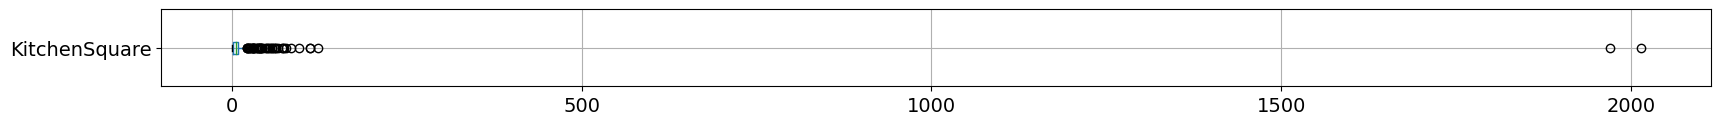

In [22]:
fig, ax = plt.subplots(figsize=(20, 1))
train_df.boxplot(column='KitchenSquare', vert=False)
ax.xaxis.set_major_locator(MultipleLocator(base=500))
plt.show()

In [23]:
train_df[train_df['KitchenSquare'] < 3].sort_values(by='Price', ascending=False)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8803,13226,73,2.00,73.21,NaN,1.00,16,17.00,2019,0.04,B,B,37,6856,84,1940.00,2,5,B,633233.47
2041,15251,17,3.00,125.02,NaN,0.00,24,0.00,1977,0.09,B,B,23,4635,5,3300.00,2,4,B,627525.07
7173,3206,54,3.00,125.12,NaN,1.00,4,1.00,1977,0.01,B,B,30,5285,0,645.00,6,6,B,625820.04
3121,98,54,3.00,120.89,120.97,1.00,7,1.00,2015,0.01,B,B,30,5285,0,645.00,6,6,B,621002.91
6829,13630,24,3.00,127.14,4.81,1.00,3,1.00,2017,0.11,B,B,50,12238,8,1970.00,2,3,B,611250.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,1575,23,1.00,33.56,33.33,1.00,5,9.00,2014,0.03,B,B,0,168,0,NaN,0,0,B,61670.35
4143,2950,23,1.00,27.78,26.72,0.00,5,4.00,2017,0.03,B,B,0,168,0,NaN,0,0,B,60918.57
8563,2648,23,1.00,34.67,NaN,0.00,4,0.00,1977,0.01,B,B,1,388,0,NaN,0,0,B,60828.26
8191,1579,23,1.00,27.33,NaN,1.00,10,12.00,1977,0.03,B,B,0,168,0,NaN,0,0,B,60825.03


По данным rbc.ru площадь кухни в Москве составляет от 9 до 15 м^2, доля квартир с площадью кухни меньше 4 метров составляет менее 0.4 %. В наших данных 2460 объектов с площадью кухни 1 м^2. Сам по себе столбец выглядит мусорным

**HouseFloor, Floor**

In [24]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

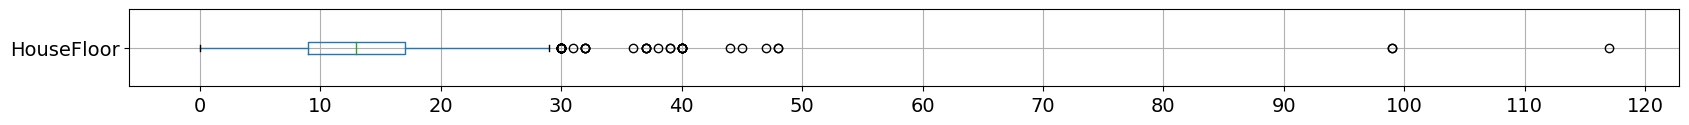

In [25]:
fig, ax = plt.subplots(figsize=(20, 1))
train_df.boxplot(column='HouseFloor', vert=False)
ax.xaxis.set_major_locator(MultipleLocator(base=10))
plt.show()

In [26]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

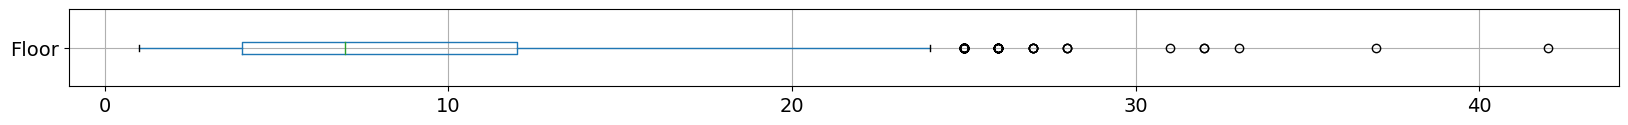

In [27]:
fig, ax = plt.subplots(figsize=(20, 1))
train_df.boxplot(column='Floor', vert=False)
ax.xaxis.set_major_locator(MultipleLocator(base=10))
plt.show()

**HouseYear**

In [28]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

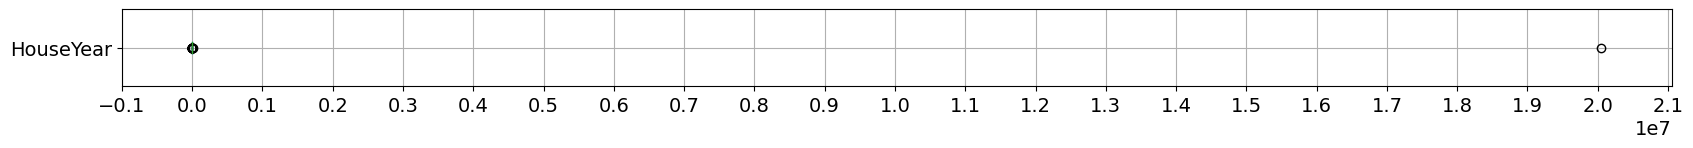

In [29]:
fig, ax = plt.subplots(figsize=(20, 1))
train_df.boxplot(column='HouseYear', vert=False)
ax.xaxis.set_major_locator(MultipleLocator(base=1000000))
plt.show()

In [30]:
train_df[train_df['HouseYear'] > 2022]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.00,44.79,28.36,5.00,4,9.00,4968,0.32,B,B,25,4756,16,2857.00,5,8,B,243028.60
9163,10814,109,1.00,37.27,20.24,9.00,9,12.00,20052011,0.14,B,B,30,6141,10,262.00,3,6,B,254084.53


Два выброса. Один похож на то, что дату указали в качестве периода

### Подготовка данных

In [31]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [32]:
class DataPreprocessing:
    def __init__(self):
        self.medians = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None


        
    def fit(self, df):
        # Medians and quantiles
        self.medians = df.median() # medians
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.999) 
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.001) 
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03) 
        self.max_floor = df['Floor'].max()
        
        
        # Compute mean Helthcare_1 value in each district
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        # Life Square fillna
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.2), inplace=True)


        # Rooms
        # Fillna with medians         
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Compute median room square and fill outliers with LifeSquare/Room_square 
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        # Square
        # If LifeSquare > Square: exchange values
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))


        # LifeSquare
        # Fill outliers with (Square - KithcenSquare)
        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, ['Square']] - df.loc[ls_condition, ['KitchenSquare']]
  
        
        # KitchenSquare
        # Fill outliers with (Square - LifeSquare - 10% of Square)
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = df.loc[condition_kitchen_square, 'Square'] - df.loc[condition_kitchen_square, 'LifeSquare'] \
        - (df.loc[condition_kitchen_square, 'Square'] * 0.1)


        # Ecology and Shops
        # Switch to binary
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        
        # HouseFloor
        # If HouseFloor < Floor: exchange values
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']

        
        # HouseYear
        # If HouseYear > current year set median value
        
        df.loc[(df['HouseYear'] == 20052011), 'HouseYear'] = 2005
        current_year = datetime.now().year
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        
        
        # Healthcare
        # Fillna with dictrict healthcare value. (If district has no healthcare value fill with medians)      
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        
        # Drop Id
        df.drop(['Id'], axis=1, inplace=True)

        
        # Fillna just in case
        df.fillna(self.medians, inplace=True)
        return df

### Построение новых признаков

In [33]:
class FeatureGenetator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
    
    def transform(self, df):
        # How old is the district      
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Median square of flat in each district
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        

        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor'], axis=1, inplace=True)
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        
        return df

## 2. Обработка данных

In [34]:
# Загрузим первоначальные данные
X = pd.read_csv(TRAIN_DATASET_PATH)
y = X['Price']
test = pd.read_csv(TEST_DATASET_PATH)

In [35]:
# Обработка выбросов и пропусков
preprocessor = DataPreprocessing()
preprocessor.fit(X)
X = preprocessor.transform(X)
test = preprocessor.transform(test)

In [36]:
# Построение новых признаков
features_gen = FeatureGenetator()
features_gen.fit(X)
X = features_gen.transform(X)
test = features_gen.transform(test)

In [37]:
# Обработка типов данных
X = reduce_memory_usage(X)
test = reduce_memory_usage(test)

Mem. usage decreased to 0.71 Mb (51.3% reduction)
Mem. usage decreased to 0.31 Mb (54.2% reduction)


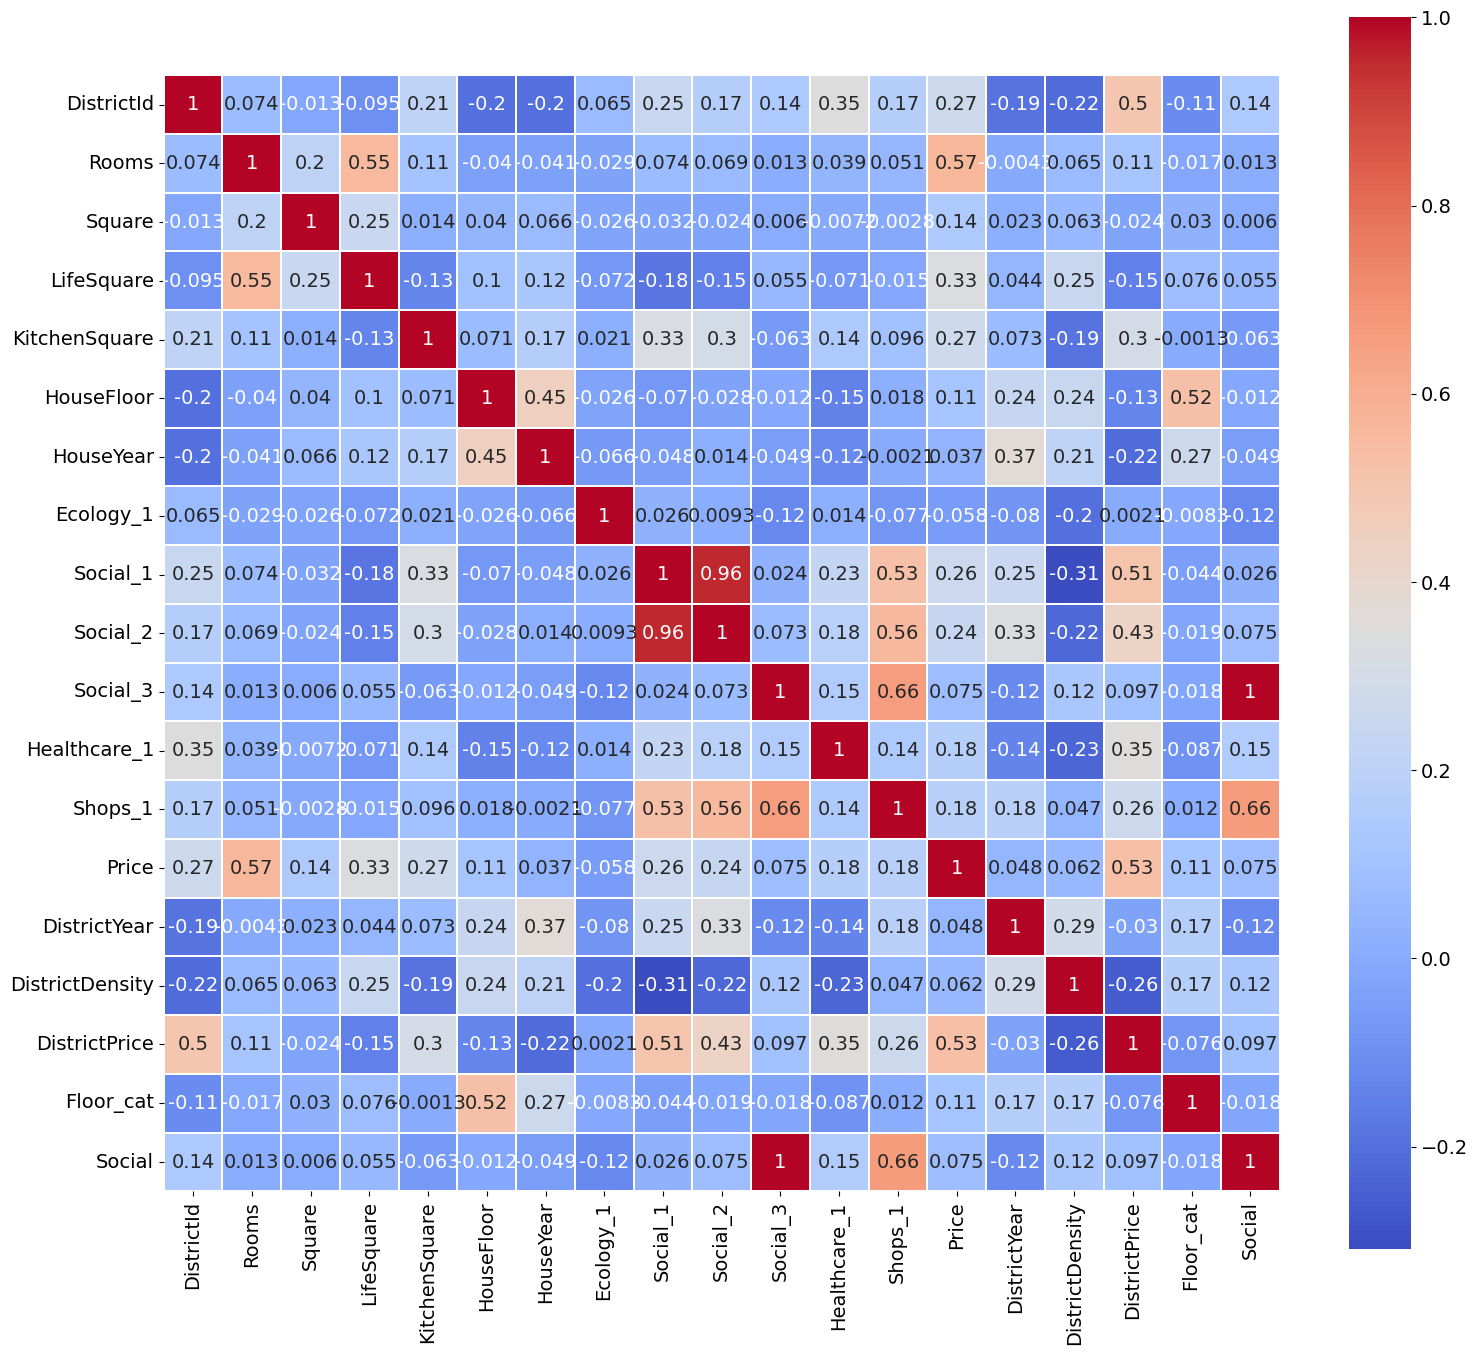

In [38]:
# Посмотрим матрицу корреляции
df_corr=X.corr()
plt.figure(figsize=(18,16))
sns.heatmap(df_corr, annot=True, linewidths=0.3, cmap='coolwarm', square=True)
plt.show()

'Price' больше всего коррелирует с 'Rooms' и 'DistrictPrice'. Предположительно, они могут оказать на модель большое влияние

In [39]:
# Удалим целевую переменную из тренировочных данных
X.drop('Price', axis=1, inplace=True)

In [40]:
# Разделим данные на тренировочные и проверочные (valid)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [41]:
# Убедимся, что нет пропущенных данных
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test.isna().sum().sum()

(0, 0, 0)

## 3. Построение модели

**Обучение**

In [42]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
model=GradientBoostingRegressor(learning_rate=0.02, max_depth=5, max_features=0.5, n_estimators=700, random_state=24 )
model.fit(X_train, y_train)
pred=model.predict(X_valid)

CPU times: total: 9 s
Wall time: 9.01 s


**Оценка модели**

In [43]:
model.score(X_train,y_train)

0.8870701447639171

In [44]:
model.score(X_valid,y_valid)

0.7667703341361527

In [45]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.887
Test R2:	0.767


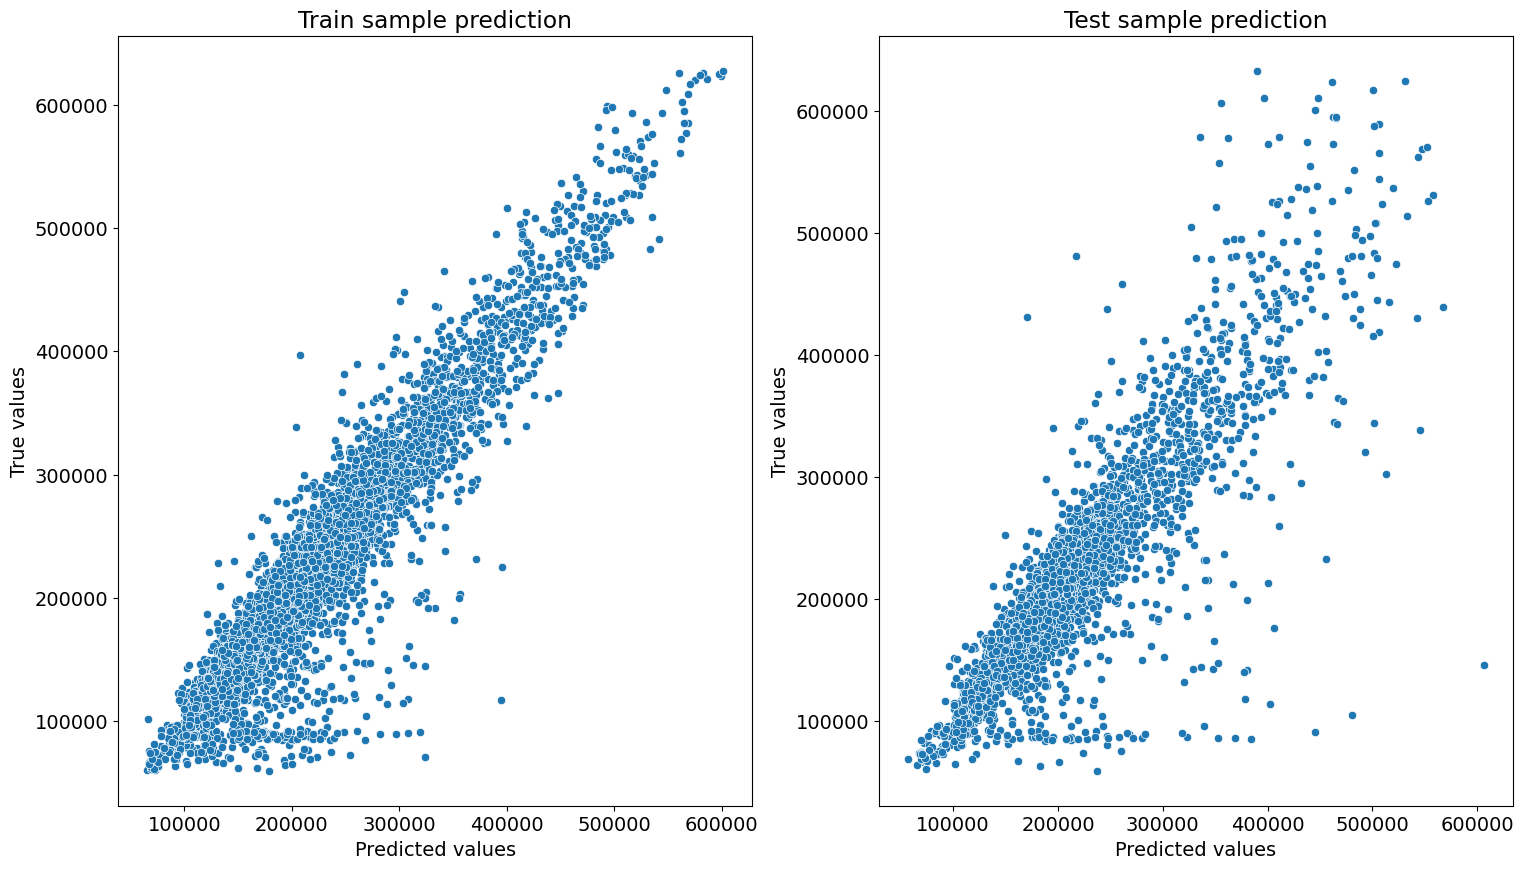

In [46]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Есть значительные отклонения в сторону увеличения в предсказаниях для недорогого жилья

**Важность признаков**

In [47]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.32
15,DistrictPrice,0.26
1,Rooms,0.12
3,LifeSquare,0.05
8,Social_1,0.03
9,Social_2,0.03
17,Social,0.03
4,KitchenSquare,0.02
6,HouseYear,0.02
5,HouseFloor,0.02


Самыми важными признаками оказались 'Square', 'DistrictPrice' и 'Rooms'

## 4. Предсказание

In [48]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.00
1,5925,200000.00
2,960,200000.00
3,3848,200000.00
4,746,200000.00


In [49]:
predictions = model.predict(test)
predictions

array([171660.86217304, 123764.22049576, 149638.47241733, ...,
       146834.59516816, 186056.58449776, 266023.89382451])

In [50]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,171660.86
1,5925,123764.22
2,960,149638.47
3,3848,102756.42
4,746,181577.81


In [51]:
submit.to_csv('rf_submit.csv', index=False)